In [1]:
import pandas as pd
import numpy as np
import sklearn.linear_model as linear_model
import seaborn as sbn
import matplotlib.pyplot as plt
import re
import sklearn.preprocessing as sklearn_processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import math
from sklearn.feature_selection import chi2
import scipy.stats as stats

In [2]:
train_df = pd.read_csv('titanictrain.csv')

In [3]:
train_df.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
473,474,1,2,"Jerwan, Mrs. Amin S (Marie Marthe Thuillard)",female,23.0,0,0,SC/AH Basle 541,13.7917,D,C
268,269,1,1,"Graham, Mrs. William Thompson (Edith Junkins)",female,58.0,0,1,PC 17582,153.4625,C125,S
441,442,0,3,"Hampe, Mr. Leon",male,20.0,0,0,345769,9.5000,NaN,S
796,797,1,1,"Leader, Dr. Alice (Farnham)",female,49.0,0,0,17465,25.9292,D17,S
567,568,0,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29.0,0,4,349909,21.0750,NaN,S
239,240,0,2,"Hunt, Mr. George Henry",male,33.0,0,0,SCO/W 1585,12.2750,NaN,S
398,399,0,2,"Pain, Dr. Alfred",male,23.0,0,0,244278,10.5000,NaN,S
368,369,1,3,"Jermyn, Miss. Annie",female,NaN,0,0,14313,7.7500,NaN,Q
729,730,0,3,"Ilmakangas, Miss. Pieta Sofia",female,25.0,1,0,STON/O2. 3101271,7.9250,NaN,S
390,391,1,1,"Carter, Mr. William Ernest",male,36.0,1,2,113760,120.0000,B96 B98,S


In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### Clean Data

#### Age has minimal null fields. Let's clean up

In [6]:
train_df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [7]:
age_mean = train_df['Age'].mean()

In [8]:
train_df['Age'].count()

714

In [9]:
train_df['Age'].sum()/train_df['Age'].count()

29.69911764705882

In [10]:
train_df['Age'].replace({np.NaN:age_mean}, inplace=True)

In [11]:
train_df['Age'].astype('int')

0      22
1      38
2      26
3      35
4      35
       ..
886    27
887    19
888    29
889    26
890    32
Name: Age, Length: 891, dtype: int64

#### Drop Cabin because we do not have upto have of the record

In [12]:
train_df.drop(labels=['Cabin'], axis=1, inplace=True)

#### Drop Ticket because it does not look useful

In [13]:
train_df.drop(labels=['Ticket'], axis=1, inplace=True)

#### Embarked has 2 null fields. We can just Forward fill this

In [14]:
train_df['Embarked'].fillna(method='ffill', inplace=True)

In [15]:
train_df.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
82,83,1,3,"McDermott, Miss. Brigdet Delia",female,29.699118,0,0,7.7875,Q
395,396,0,3,"Johansson, Mr. Erik",male,22.000000,0,0,7.7958,S
221,222,0,2,"Bracken, Mr. James H",male,27.000000,0,0,13.0000,S
443,444,1,2,"Reynaldo, Ms. Encarnacion",female,28.000000,0,0,13.0000,S
94,95,0,3,"Coxon, Mr. Daniel",male,59.000000,0,0,7.2500,S
152,153,0,3,"Meo, Mr. Alfonzo",male,55.500000,0,0,8.0500,S
318,319,1,1,"Wick, Miss. Mary Natalie",female,31.000000,0,2,164.8667,S
684,685,0,2,"Brown, Mr. Thomas William Solomon",male,60.000000,1,1,39.0000,S
714,715,0,2,"Greenberg, Mr. Samuel",male,52.000000,0,0,13.0000,S
580,581,1,2,"Christy, Miss. Julie Rachel",female,25.000000,1,1,30.0000,S


#### Title can be extracted as new feature from coulumn name

In [16]:
def find_title_from_name(name):
    comma_index = name.index(',')
    dot_index = name.index('.')
    return name[comma_index+1:dot_index].strip()

In [17]:
train_df['Title'] = train_df['Name'].apply(lambda x:find_title_from_name(x))

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Embarked     891 non-null    object 
 10  Title        891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


#### Remove unnecessary Column like Passenger, Name

In [19]:
train_df.drop(labels=['Name', 'PassengerId'], axis=1, inplace=True)

In [20]:
train_df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [21]:
label_encoder = sklearn_processing.LabelEncoder()
label_encoder.fit_transform(train_df['Title'])
train_df['Title_cat'] = label_encoder.fit_transform(train_df['Title'])
train_df['Embarked_cat'] = label_encoder.fit_transform(train_df['Embarked'])
train_df['Sex_cat'] = label_encoder.fit_transform(train_df['Sex'])

In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int64  
 1   Pclass        891 non-null    int64  
 2   Sex           891 non-null    object 
 3   Age           891 non-null    float64
 4   SibSp         891 non-null    int64  
 5   Parch         891 non-null    int64  
 6   Fare          891 non-null    float64
 7   Embarked      891 non-null    object 
 8   Title         891 non-null    object 
 9   Title_cat     891 non-null    int64  
 10  Embarked_cat  891 non-null    int64  
 11  Sex_cat       891 non-null    int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 83.7+ KB


#### Check for correlation and remove columns that are not necessary

In [23]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,Title_cat,Embarked_cat,Sex_cat
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,10.241302,1.533109,0.647587
std,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429,1.830798,0.793069,0.477990
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,8.000000,1.000000,0.000000
50%,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200,11.000000,2.000000,1.000000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,11.000000,2.000000,1.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,16.000000,2.000000,1.000000


In [24]:
train_df[train_df['Age'] < 1]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Title_cat,Embarked_cat,Sex_cat
78,1,2,male,0.83,0,2,29.0000,S,Master,7,2,1
305,1,1,male,0.92,1,2,151.5500,S,Master,7,2,1
469,1,3,female,0.75,2,1,19.2583,C,Miss,8,0,0
644,1,3,female,0.75,2,1,19.2583,C,Miss,8,0,0
755,1,2,male,0.67,1,1,14.5000,S,Master,7,2,1
803,1,3,male,0.42,0,1,8.5167,C,Master,7,0,1
831,1,2,male,0.83,1,1,18.7500,S,Master,7,2,1


In [25]:
train_df['Age'] = train_df['Age'].astype('int')

In [26]:
train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Title_cat,Embarked_cat,Sex_cat
0,0,3,male,22,1,0,7.2500,S,Mr,11,2,1
1,1,1,female,38,1,0,71.2833,C,Mrs,12,0,0
2,1,3,female,26,0,0,7.9250,S,Miss,8,2,0
3,1,1,female,35,1,0,53.1000,S,Mrs,12,2,0
4,0,3,male,35,0,0,8.0500,S,Mr,11,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27,0,0,13.0000,S,Rev,14,2,1
887,1,1,female,19,0,0,30.0000,S,Miss,8,2,0
888,0,3,female,29,1,2,23.4500,S,Miss,8,2,0
889,1,1,male,26,0,0,30.0000,C,Mr,11,0,1


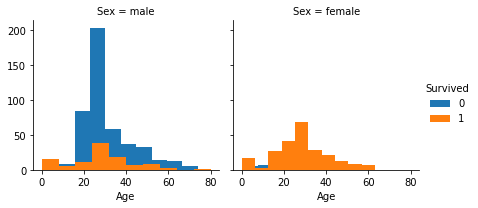

In [27]:
graph = sbn.FacetGrid(train_df, col='Sex', hue='Survived')
graph.map(plt.hist, 'Age').add_legend()
plt.show()

In [28]:
train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Title_cat,Embarked_cat,Sex_cat
0,0,3,male,22,1,0,7.2500,S,Mr,11,2,1
1,1,1,female,38,1,0,71.2833,C,Mrs,12,0,0
2,1,3,female,26,0,0,7.9250,S,Miss,8,2,0
3,1,1,female,35,1,0,53.1000,S,Mrs,12,2,0
4,0,3,male,35,0,0,8.0500,S,Mr,11,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27,0,0,13.0000,S,Rev,14,2,1
887,1,1,female,19,0,0,30.0000,S,Miss,8,2,0
888,0,3,female,29,1,2,23.4500,S,Miss,8,2,0
889,1,1,male,26,0,0,30.0000,C,Mr,11,0,1


In [29]:
df_cat_vals = train_df[['Pclass', 'Sex_cat', 'Title_cat', 'Embarked_cat', 'Parch']]

In [30]:
chi2(df_cat_vals, train_df['Survived'])

(array([30.87369944, 92.70244698, 10.92153609, 10.89320987, 10.09749911]),
 array([2.75378563e-08, 6.07783826e-22, 9.50527622e-04, 9.65174232e-04,
        1.48470676e-03]))

- Null hypothesis rejected. i.e. Pclass', 'Sex_cat', 'Title_cat', 'Embarked_cat', 'Parch' are all dependent

In [31]:
train_df['Age'] = train_df['Age'].astype('int')

In [32]:
train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Title_cat,Embarked_cat,Sex_cat
0,0,3,male,22,1,0,7.2500,S,Mr,11,2,1
1,1,1,female,38,1,0,71.2833,C,Mrs,12,0,0
2,1,3,female,26,0,0,7.9250,S,Miss,8,2,0
3,1,1,female,35,1,0,53.1000,S,Mrs,12,2,0
4,0,3,male,35,0,0,8.0500,S,Mr,11,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27,0,0,13.0000,S,Rev,14,2,1
887,1,1,female,19,0,0,30.0000,S,Miss,8,2,0
888,0,3,female,29,1,2,23.4500,S,Miss,8,2,0
889,1,1,male,26,0,0,30.0000,C,Mr,11,0,1


In [33]:
stats.normaltest(train_df['Fare'])

NormaltestResult(statistic=904.5872705326926, pvalue=3.727091062842147e-197)

In [34]:
rv = np.random.normal(size=30)

In [35]:
stats.normaltest(rv)

NormaltestResult(statistic=0.3944584802505604, pvalue=0.8210024050445586)

In [36]:
### Set range for ages so it can be categorised

In [37]:
# train_df['Age_cat'] = pd.cut(x = train_df['Age'], bins=[0, 1, 12, 19, 60, 140], labels=[0,1,2,3,4])

In [38]:
train_df['Age'].max()

80

In [39]:
# train_df['Age_cat'].unique()

In [40]:
# train_df['SibSp'].unique()

In [41]:
# train_df['Age_cat'].corr(train_df['Survived'])

In [42]:
train_df = pd.get_dummies(train_df, columns=["Pclass", "Sex_cat", "Title_cat", "Embarked_cat","Parch"],
               prefix=["Pclass", "Sex_is", "Title_is", "Embarked_is", "Parch"])

In [43]:
standard_scaler = sklearn_processing.StandardScaler()
train_df[['Fare']] = standard_scaler.fit_transform(train_df[['Fare']])
train_df[['Age']] = standard_scaler.fit_transform(train_df[['Age']])

In [44]:
train_df[['SibSp']] = standard_scaler.fit_transform(train_df[['SibSp']])

In [45]:
train_df

,Survived,Sex,Age,SibSp,Fare,Embarked,Title,Pclass_1,Pclass_2,Pclass_3,...,Embarked_is_0,Embarked_is_1,Embarked_is_2,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
0,0,male,-0.580044,0.432793,-0.502445,S,Mr,0,0,1,...,0,0,1,1,0,0,0,0,0,0
1,1,female,0.650112,0.432793,0.786845,C,Mrs,1,0,0,...,1,0,0,1,0,0,0,0,0,0
2,1,female,-0.272505,-0.474545,-0.488854,S,Miss,0,0,1,...,0,0,1,1,0,0,0,0,0,0
3,1,female,0.419458,0.432793,0.420730,S,Mrs,1,0,0,...,0,0,1,1,0,0,0,0,0,0
4,0,male,0.419458,-0.474545,-0.486337,S,Mr,0,0,1,...,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,male,-0.195620,-0.474545,-0.386671,S,Rev,0,1,0,...,0,0,1,1,0,0,0,0,0,0
887,1,female,-0.810699,-0.474545,-0.044381,S,Miss,1,0,0,...,0,0,1,1,0,0,0,0,0,0
888,0,female,-0.041851,0.432793,-0.176263,S,Miss,0,0,1,...,0,0,1,0,0,1,0,0,0,0
889,1,male,-0.272505,-0.474545,-0.044381,C,Mr,1,0,0,...,1,0,0,1,0,0,0,0,0,0


In [46]:
train_df.corr()

,Survived,Age,SibSp,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_is_0,Sex_is_1,Title_is_0,...,Embarked_is_0,Embarked_is_1,Embarked_is_2,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
Survived,1.000000,-0.067809,-0.035322,0.257307,0.285904,0.093349,-0.322308,0.543351,-0.543351,-0.026456,...,0.171485,0.008660,-0.155660,-0.147408,0.134174,0.075020,0.033391,-0.053002,-0.028398,-0.026456
Age,-0.067809,1.000000,-0.232743,0.093856,0.321850,0.010199,-0.285608,-0.082533,0.082533,0.104262,...,0.032577,-0.011131,-0.021504,0.258754,-0.145419,-0.255828,0.021114,0.077217,0.055769,0.034678
SibSp,-0.035322,-0.232743,1.000000,0.159651,-0.054582,-0.055932,0.092548,0.114631,-0.114631,0.014507,...,-0.060751,-0.028085,0.070941,-0.462241,0.199138,0.438714,0.032512,0.013831,0.005248,0.014507
Fare,0.257307,0.093856,0.159651,1.000000,0.591711,-0.118557,-0.413333,0.182333,-0.182333,0.026184,...,0.271478,-0.112712,-0.166603,-0.237717,0.114650,0.203206,-0.009457,0.071344,0.000523,0.009918
Pclass_1,0.285904,0.321850,-0.054582,0.591711,1.000000,-0.288585,-0.626738,0.098013,-0.098013,0.059256,...,0.300810,-0.147418,-0.170379,-0.008373,0.018496,0.014713,-0.042496,0.001187,-0.042496,-0.018962
Pclass_2,0.093349,0.010199,-0.055932,-0.118557,-0.288585,1.000000,-0.565210,0.064746,-0.064746,-0.017100,...,-0.126591,-0.128586,0.192061,-0.039091,0.062425,-0.005051,0.035908,-0.034258,-0.038324,-0.017100
Pclass_3,-0.322308,-0.285608,0.092548,-0.413333,-0.626738,-0.565210,1.000000,-0.137143,0.137143,-0.037138,...,-0.156152,0.231667,-0.009511,0.039029,-0.066741,-0.008566,0.007391,0.026859,0.067804,0.030255
Sex_is_0,0.543351,-0.082533,0.114631,0.182333,0.098013,0.064746,-0.137143,1.000000,-1.000000,-0.024728,...,0.086546,0.079067,-0.125722,-0.247523,0.127636,0.170993,0.070383,0.020746,0.070383,0.045439
Sex_is_1,-0.543351,0.082533,-0.114631,-0.182333,-0.098013,-0.064746,0.137143,-1.000000,1.000000,0.024728,...,-0.086546,-0.079067,0.125722,0.247523,-0.127636,-0.170993,-0.070383,-0.020746,-0.070383,-0.045439
Title_is_0,-0.026456,0.104262,0.014507,0.026184,0.059256,-0.017100,-0.037138,-0.024728,0.024728,1.000000,...,-0.016217,-0.010383,0.020759,-0.059804,0.085793,-0.010528,-0.002518,-0.002251,-0.002518,-0.001124


In [47]:
X = train_df.drop(['Sex', 'Age', 'Title', 'Embarked', 'Fare', 'Sex', 'Survived', 'SibSp'], axis=1)

In [48]:
X

,Pclass_1,Pclass_2,Pclass_3,Sex_is_0,Sex_is_1,Title_is_0,Title_is_1,Title_is_2,Title_is_3,Title_is_4,...,Embarked_is_0,Embarked_is_1,Embarked_is_2,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
0,0,0,1,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,0,0,1,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,1,0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
887,1,0,0,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
888,0,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
889,1,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [49]:
y = train_df['Survived']

In [50]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)

In [51]:
log_reg = linear_model.LogisticRegression()
log_reg.fit(x_train, y_train)

LogisticRegression()

In [52]:
log_reg.score(x_test, y_test)

0.8222222222222222

In [53]:
predict_y = log_reg.predict(x_test)

In [54]:
f1_score(y_test, predict_y)

0.75

In [55]:
acc_log = round(log_reg.score(x_train, y_train) * 100, 2)

In [56]:
acc_log

82.27

In [57]:
print(classification_report(y_test, predict_y))

              precision    recall  f1-score   support

           0       0.79      0.94      0.86        53
           1       0.89      0.65      0.75        37

    accuracy                           0.82        90
   macro avg       0.84      0.80      0.81        90
weighted avg       0.83      0.82      0.82        90



In [58]:
y_test

707    1
37     0
615    1
169    0
68     1
      ..
84     1
471    0
384    0
726    1
342    0
Name: Survived, Length: 90, dtype: int64

In [59]:
predict_y

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0])

In [60]:
x_test

,Pclass_1,Pclass_2,Pclass_3,Sex_is_0,Sex_is_1,Title_is_0,Title_is_1,Title_is_2,Title_is_3,Title_is_4,...,Embarked_is_0,Embarked_is_1,Embarked_is_2,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
707,1,0,0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
37,0,0,1,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
615,0,1,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
169,0,0,1,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
68,0,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,0,1,0,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
471,0,0,1,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
384,0,0,1,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
726,0,1,0,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [61]:
X

,Pclass_1,Pclass_2,Pclass_3,Sex_is_0,Sex_is_1,Title_is_0,Title_is_1,Title_is_2,Title_is_3,Title_is_4,...,Embarked_is_0,Embarked_is_1,Embarked_is_2,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
0,0,0,1,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,0,0,1,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,1,0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
887,1,0,0,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
888,0,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
889,1,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [63]:
!pip3 install opendatasets

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     |████████████████████████████████| 58 kB 378 kB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 97 kB 888 kB/s            
     |████████████████████████████████| 78 kB 1.1 MB/s            
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=50ee39add70e647d274e23dcc85e7e5743a8fc66563d7366f68ec116d6a63b39
  Stored in directory: /Users/user/Library/Caches/pip/wheels/ac/b2/c3/fa4706d469b5879105991d1c8be9a3c2ef329ba9fe2ce5085e
Successfully built kaggle
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discuss

In [64]:
import opendatasets as od

In [ ]:
od.download('https://www.kaggle.com/ruchi798/mobile-phone-tweets/download')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: saheedyusuf
Your Kaggle Key: ········


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 2.00M/3.91M [00:01<00:01, 1.57MB/s]